# Iris Machine Learning
## by James Crofts

Accuracy of K-Means:  0.8866666666666667

Running EM algorithm:

Initial values for EM, computed from K-Means:
Probabilities: 
 [0.33333333 0.26       0.40666667]
Centroids: 
 [[ 2.87050234 -5.50524368]
 [ 7.85779422 -5.58707828]
 [ 6.17577661 -4.98443152]]
Covariances: 
 [[[ 0.04777048 -0.05590782]
  [-0.05590782  0.21472356]]

 [[ 0.35155689 -0.10572859]
  [-0.10572859  0.13213395]]

 [[ 0.3777503  -0.10985456]
  [-0.10985456  0.14495779]]] 


EM converged after 22 iterations

Final values after running EM:
Probabilities: 
 [0.33333333 0.36212951 0.30453715]
Centroids: 
 [[ 2.87050234 -5.50524368]
 [ 7.521516   -5.32948024]
 [ 6.01156882 -5.08864157]]
Covariances: 
 [[[ 0.04777048 -0.05590782]
  [-0.05590782  0.21472356]]

 [[ 0.57096311 -0.29359732]
  [-0.29359732  0.23121386]]

 [[ 0.36059607 -0.21821184]
  [-0.21821184  0.18907625]]]

EM Accuracy: 0.98


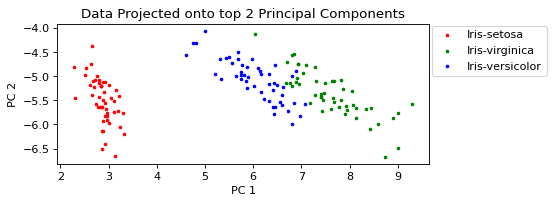

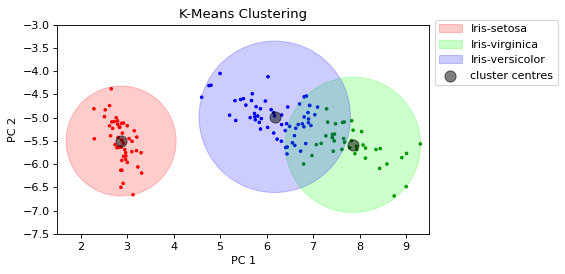

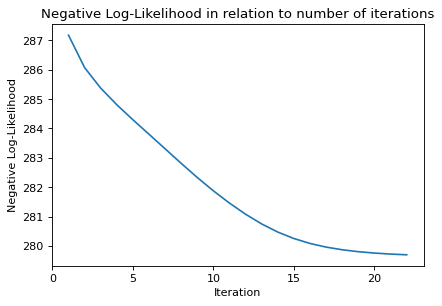

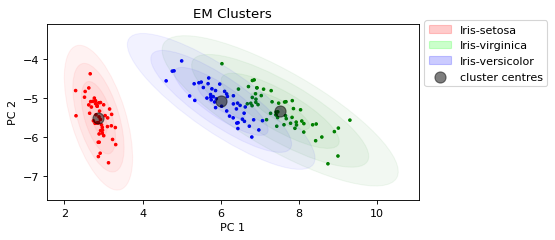

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt 
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal


#function from CS342
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))



#return a matrix of ordered PCs
def PCA(X):
    #create copy of inputted data
    data = np.copy(X)
    
    #get means of each feature
    means = np.mean(data, axis=0)
    
    #centre the data by subtracting the means
    for i in range(0, len(X)):
        for j in range(0, len(means)):
            data[i][j] = data[i][j] - means[j]
            
    #SVD
    U, S, V = np.linalg.svd(data, full_matrices=True)
    return V



#compute basic accuracy
def accuracy(predictions, labels):
    return np.sum(predictions == labels) / len(labels)

#compute accuracy for hard assignments of EM
def getAccuracyEM(r, y):
    #get hard assignments
    assignments = np.zeros(len(r))
    for i in range(0, len(r)):
        assignments[i] = np.where(r[i] == np.amax(r[i]))[0]

    #get accuracy
    emPreds = ['Iris-setosa' if l == 0 else ('Iris-virginica' if l == 1 else 'Iris-versicolor') for l in assignments]
    return accuracy(emPreds, np.transpose(y)[0])



############## Start of Utility Functions for EM Algorithm ##############

def updateClusterProbabilities(r, clusters):
    sums = np.sum(r, axis=0)
    probs = np.zeros((clusters))
    for c in range(0, clusters):
        probs[c] = sums[c] / len(r)
    return probs

def updateClusterCentroids(x, r, clusters):
    sums = np.sum(r, axis=0)
    rows, cols = x.shape
    cents = np.zeros((clusters, cols))
    for c in range(0, clusters):
        for i in range(0, len(x)): cents[c] += r[i][c] * x[i]
        cents[c] /= sums[c]
    return cents

def updateClusterCovariances(x, r, cents, clusters):
    sums = np.sum(r, axis=0)
    rows, cols = x.shape
    covs = np.zeros((clusters, cols, cols))
    for c in range(0, clusters):
        for i in range(0, len(x)):
            temp = x[i] - cents[c]
            temp = np.atleast_2d(temp).T #convert to column vector
            covs[c] += r[i][c] * np.matmul(temp, temp.T)
        covs[c] /= sums[c]
    return covs

def updateResponsibilities(x, r, probs, cents, covs, clusters):
    #first compute denominators for each responsibility
    #note that each responsiblity for each cluster for a given x_i has the same denominator
    denominators = np.zeros((len(x)))
    for i in range(0, len(x)):
        for c in range(0, clusters):
            denominators[i] += multivariate_normal.pdf(x[i], cents[c], covs[c]) * probs[c]
            
    #calculate responsibilities for each x_i
    for i in range(0, len(x)):
        for c in range(0, clusters):
            r[i][c] = (multivariate_normal.pdf(x[i], cents[c], covs[c]) * probs[c]) / denominators[i]

def negativeLogLikelihood(x, r, probs, cents, covs, clusters):
    result = 1
    for i in range(0, len(x)):
        temp = 0
        for c in range(0, clusters):
            temp += multivariate_normal.pdf(x[i], cents[c], covs[c]) * probs[c]
        result += math.log(temp)
    return -result

############## End of Utility Functions for EM Algorithm ##############



#compute the initial values from K-Means for the EM algorithm
def EMInitialValues(x, kmeansLabels, clusters):
    r = np.zeros((len(kmeansLabels), clusters)) #r are our responsibilites for each cluster
    for i in range(0, len(kmeansLabels)): #set responsibilites using labels from K-Means
        r[i][kmeansLabels[i]] = 1
    clusterProbs = updateClusterProbabilities(r, clusters)
    clusterCents = updateClusterCentroids(x, r, clusters)
    clusterCovs = updateClusterCovariances(x, r, clusterCents, clusters)
    return clusterProbs, clusterCents, clusterCovs

#performs EM algorithm and returns:
#- soft assignments to each cluster
#- centroids for each cluster for plotting ellipses and for displaying final values
#- covariances for each cluster for plotting ellipses and for displaying final values
#- negative log-likelihoods for plotting
def EM(x, kmeansLabels, clusters, tolerance, maxIterations):
    #first get initial values from K-Means
    probs, cents, covs = EMInitialValues(x, kmeansLabels, clusters)
    
    #print initial values from K-Means
    print("\nInitial values for EM, computed from K-Means:")
    print("Probabilities: \n", probs)
    print("Centroids: \n", cents)
    print("Covariances: \n", covs, "\n")
    
    #create responsibilities array
    r = np.zeros((len(x), clusters))
    
    #variables for tracking progress
    converged = False
    iterations = 0
    likelihoods = np.zeros((maxIterations+1))
    
    while iterations < maxIterations:
        #E-Step
        updateResponsibilities(x, r, probs, cents, covs, clusters)
                
        #M-Step
        probs = updateClusterProbabilities(r, clusters)
        cents = updateClusterCentroids(x, r, clusters)
        covs = updateClusterCovariances(x, r, cents, clusters)
        
        #Check for convergence using negative log-likelihood
        iterations += 1
        likelihoods[iterations] = negativeLogLikelihood(x, r, probs, cents, covs, clusters)
        if (iterations > 1 and abs((likelihoods[iterations-1] - likelihoods[iterations]) / likelihoods[iterations-1]) < tolerance):
            converged = True
            break
    
    if (converged): print("\nEM converged after", iterations, "iterations\n")
    else: print("\nEM did not converge after", iterations, "iterations\n")
    print("Final values after running EM:")
    print("Probabilities: \n", probs)
    print("Centroids: \n", cents)
    print("Covariances: \n", covs)
    
    return r, cents, covs, likelihoods[1:iterations+1]
    
    
    

#import data and extract X and y matrices
data = pd.read_csv("iris.data", header=None)
X = data.iloc[:, 0:4].to_numpy()
y = data.iloc[:, 4:5].to_numpy()

#calculate PCA and take the top 2
pcs = PCA(X)
topPcs = pcs[:2]

#reduce to 2-dimensions
Z = np.matmul(X, topPcs.T)

#plot pc2 against pc1
plotData = np.transpose(Z)
fig1, ax1 = plt.subplots()
ax1.scatter(plotData[0][0:50], plotData[1][0:50], s=5, color='red', label='Iris-setosa')
ax1.scatter(plotData[0][100:150], plotData[1][100:150], s=5, color='green', label='Iris-virginica')
ax1.scatter(plotData[0][50:100], plotData[1][50:100], s=5, color='blue', label='Iris-versicolor')
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.set_aspect('equal', 'box')
fig1.set_dpi(80)
ax1.set_title("Data Projected onto top 2 Principal Components")
ax1.legend(bbox_to_anchor=(1.33, 1.03))



#now perform k-means on 2D data
kmeans = KMeans(n_clusters=3, random_state=0).fit(Z)
kmeansLabels = kmeans.labels_


#compute accuracy of k-means
kmeanPreds = ['Iris-setosa' if l == 0 else ('Iris-virginica' if l == 1 else 'Iris-versicolor') for l in kmeansLabels]
kmeansAccuracy = accuracy(kmeanPreds, np.transpose(y)[0])
print('Accuracy of K-Means: ', kmeansAccuracy)

#visualise k-means
kmeansLabelColors = ['red' if l == 0 else ('green' if l == 1 else 'blue') for l in kmeansLabels] #get label colors
centres = kmeans.cluster_centers_ #get centres
centrePoints = np.transpose(centres)

#get radius for each cluster (distance to furthest point)
distances = [0, 0, 0]
for i in range(0, 150):
    l = kmeansLabels[i]
    xCoord = centres[l][0] - Z[i][0]
    yCoord = centres[l][1] - Z[i][1]
    d = sqrt(xCoord*xCoord + yCoord*yCoord) #L2-Norm
    if d > distances[l]: distances[l] = d

#plot points, cluster centres, and cluster raidus' using circles
c0 = plt.Circle(centres[0], distances[0], color=(1, 0, 0, 0.2), label='Iris-setosa')
c1 = plt.Circle(centres[1], distances[1], color=(0, 1, 0, 0.2), label='Iris-virginica')
c2 = plt.Circle(centres[2], distances[2], color=(0, 0, 1, 0.2), label='Iris-versicolor')
fig2, ax2 = plt.subplots()
ax2.scatter(plotData[0], plotData[1], s=5, color=kmeansLabelColors)
ax2.scatter(centrePoints[0], centrePoints[1],c='black', s=100, alpha=0.5, zorder=2, label='cluster centres')
ax2.set_xlabel("PC 1")
ax2.set_ylabel("PC 2")
ax2.add_patch(c0)
ax2.add_patch(c1)
ax2.add_patch(c2)
ax2.set_title("K-Means Clustering")
ax2.set_xlim([1.5, 9.5])
ax2.set_ylim([-7.5, -3])
ax2.set_aspect('equal', 'box') #make axes have equal intervals
fig2.set_dpi(80)
ax2.legend(bbox_to_anchor=(1, 1.05))



#perform EM algorithm
print("\nRunning EM algorithm:")
r, cents, covs, likelihoods = EM(Z, kmeansLabels, 3, 1e-4, 100)

EMAccuracy = getAccuracyEM(r, y)
print("\nEM Accuracy:", EMAccuracy)

#plot objectibve function against iterations for EM
fig3, ax3 = plt.subplots()
iters = np.arange(1, len(likelihoods) + 1)
ax3.plot(iters, likelihoods)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Negative Log-Likelihood")
fig3.set_dpi(80)
ax3.set_title("Negative Log-Likelihood in relation to number of iterations")

#plot points, cluster centres, and cluster areas using ellipses
#get hard assignments and use them to find label colors
hardAssignments = np.zeros(len(r))
for i in range(0, len(r)):
    hardAssignments[i] = np.where(r[i] == np.amax(r[i]))[0]
emLabelColors = ['red' if l == 0 else ('green' if l == 1 else 'blue') for l in hardAssignments]

fig4, ax4 = plt.subplots()
ax4.scatter(plotData[0], plotData[1], s=5, color=emLabelColors) #plot points with appropriate colors

#plot ellipses and centres
ax4.scatter(cents[0][0],cents[0][1],c='black', s=100, alpha=0.5, zorder=2) #draw center of ellipse
draw_ellipse(cents[0], covs[0], alpha = 1/20, color='red', label='Iris-setosa')
ax4.scatter(cents[1][0],cents[1][1],c='black', s=100, alpha=0.5, zorder=2) #draw center of ellipse
draw_ellipse(cents[1], covs[1], alpha = 1/20, color='green', label='Iris-virginica')
ax4.scatter(cents[2][0],cents[2][1],c='black', s=100, alpha=0.5, zorder=2) #draw center of ellipse
draw_ellipse(cents[2], covs[2], alpha = 1/20, color='blue', label='Iris-versicolor')

#format graph
ax4.set_xlabel("PC 1")
ax4.set_ylabel("PC 2")
ax4.set_aspect('equal', 'box') #make axes have equal intervals
fig4.set_dpi(80)
ax4.set_title("EM Clusters")
h, l = ax2.get_legend_handles_labels() #reuse circles from k-means to get legend elements
ax4.legend(handles=h, bbox_to_anchor=(1, 1.05))

Hopefully everything is working!